# Credit Card Default Prediction
Course Project of ISOM 3360, Spring 2020 

<b>Group 21</b>

In [1]:
# Import basic libraries
import numpy as np 
import pandas as pd
import joblib # for saving models

In [2]:
# Load local data
data = pd.read_csv('data/data.csv',index_col = 'ID')


## Variables
There are 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

## Data Cleaning
- No missing values, but there are a few anomalous things
- Variable name:
    1. PAY_0 is very confusing, should be changed to PAY_1 in consistensy with other variable names
    2. Change target variable name from 'default.pay.next.month' to 'def_pay'
- Understand categorical and numerical data respectively

In [4]:
# Change variable name
data = data.rename(columns={'default.payment.next.month': 'def_pay', 'PAY_0': 'PAY_1'})

In [5]:
# To have a general idea of the default probability
data['def_pay'].value_counts()[1] / data.shape[0]

0.2212

<b>Conclusion: The dataset has a mild degree of imbalance, which is not considered as a significant problem.</b>

In [6]:
# Categorical variables
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [7]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

<b>EDUCATION has category 5 and 6 which are 'unknown', and label 0 which is undocumented. They can all be considered as missing values.</b>

In [8]:
# Missing values are filled with random value according to probability of occurrence
mask_edu_good=data['EDUCATION'].isin(range(1,5))
data['EDUCATION'].mask(~mask_edu_good,data['EDUCATION'][mask_edu_good].sample(n=(~mask_edu_good).sum(),replace=True).tolist(),inplace=True)
data['EDUCATION'].value_counts()

2    14197
1    10707
3     4971
4      125
Name: EDUCATION, dtype: int64

In [9]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

<b>MARRIAGE has a label 0 that is undocumented. It can be considered as missing value.</b>

In [10]:
mask_marriage_good=data['MARRIAGE'].isin(range(1,4))
data['MARRIAGE'].mask(~mask_marriage_good,data['MARRIAGE'][mask_marriage_good].sample(n=(~mask_marriage_good).sum(),replace=True).tolist(),inplace=True)
data['MARRIAGE'].value_counts()

2    15995
1    13682
3      323
Name: MARRIAGE, dtype: int64

 <b>One might wonder what these labels might mean something.

"Other" in education can be education lower than the high school level.

"Other" in marriage could be, for example, "divorced". </b>


In [11]:
# Create lists for relevant numerical features
repayments = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amounts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [12]:
# final check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [13]:
# export to csv
data.to_csv('data/data_clean.csv')

## Data visualization

In [14]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [15]:
# import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Numerical features

#### (1) Age

In [16]:
data['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

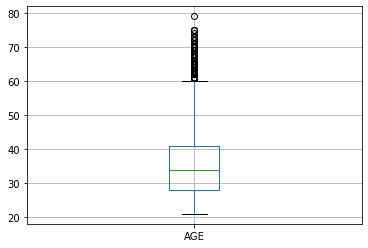

In [17]:
# boxplot for age
data.boxplot(column='AGE')

<b>Conclusion: Outliers will not be removed because they are meaningful for this feature.</b>

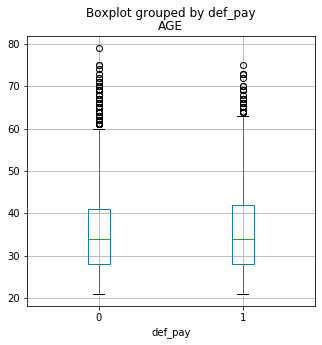

In [18]:
# boxplot for age regarding default
data.boxplot(column='AGE',by="def_pay",figsize=(5,5))

<b>Conclusion: Age distribution is different for default clients and non-default clients, which implies that age is a significant feature.</b>

#### (2) Balance limit

In [19]:
data['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

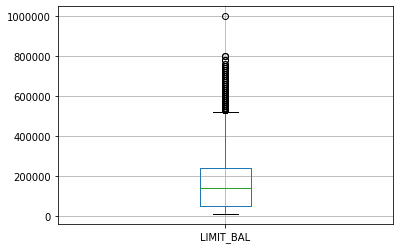

In [20]:
# boxplot for balance limit
data.boxplot(column='LIMIT_BAL')

<b>Conclusion: There are a few outliers and we will apply normalization in certain models.</b>

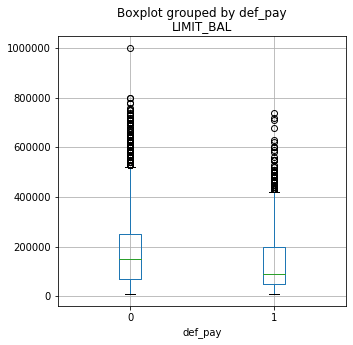

In [21]:
# boxplot for balance limit regarding default
data.boxplot(column='LIMIT_BAL',by="def_pay",figsize=(5,5))

<b>Conclusion: Balance limit distribution is different for default clients and non-default clients, whicih implies that balance limit is a significent feature.</b>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116c78510>]],
      dtype=object)

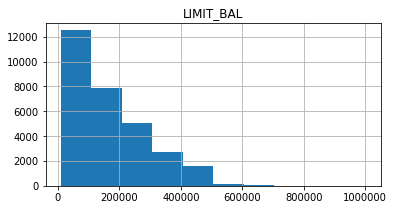

In [22]:
# histogram for balance limit
data.hist(column='LIMIT_BAL', figsize=(6, 3))

<b>Conclusion: We will apply normalization in certain models.</b>

#### (3) Payment delay

In [23]:
data[repayments].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


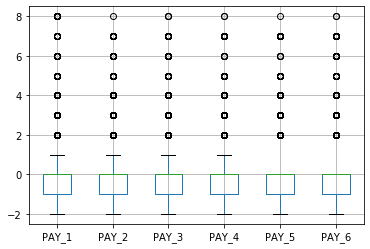

In [24]:
# boxplot for payment delay
data.boxplot(column=repayments)

<b>Conclusion: Outliers will not be removed because they are meaningful for this feature.</b>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a96ac10>,
      dtype=object)

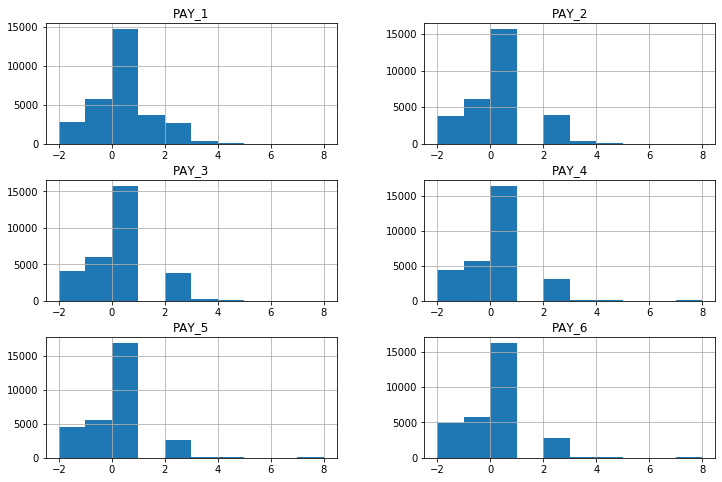

In [25]:
# histogram for payment delay
data.hist(column= repayments, figsize=(12, 8))

<b>Conclusion: Normalization is not needed because the values are clean and standard.</b>

#### (4) Bill amounts

In [26]:
data[bill_amounts].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


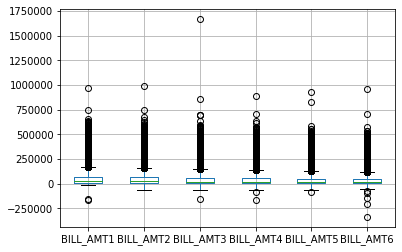

In [27]:
# boxplot for bill amounts
data.boxplot(column=bill_amounts)

<b>Conclusion: There are a few outliers and we will apply normalization in certain models.</b>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b1f2850>,
      dtype=object)

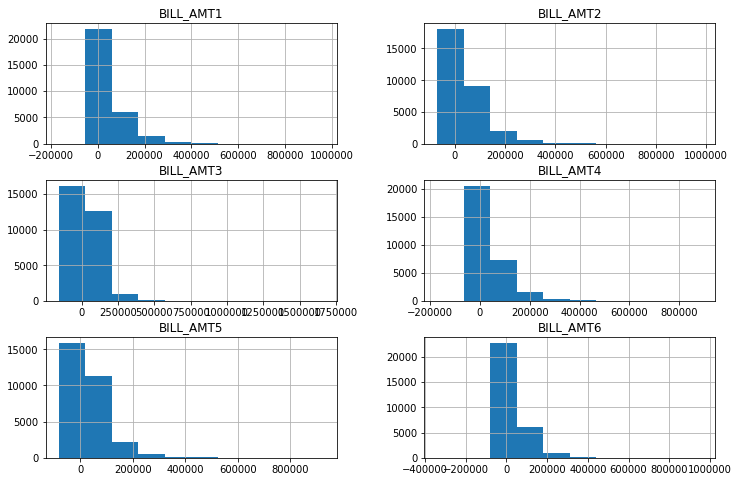

In [28]:
# histogram for bill amounts
data.hist(column= bill_amounts, figsize=(12, 8))

<b>Conclusion: We will apply normalization in certain models.</b>

#### (5) Preivous payments

In [29]:
data[payments].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


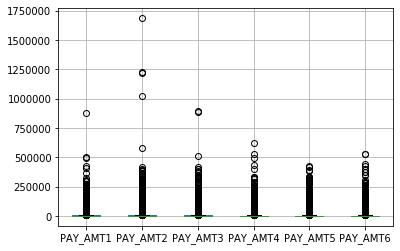

In [30]:
# boxplot for previous payments
data.boxplot(column=payments)

<b>Conclusion: There are a few outliers and we will apply normalization in certain models.</b>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b8f7110>,
      dtype=object)

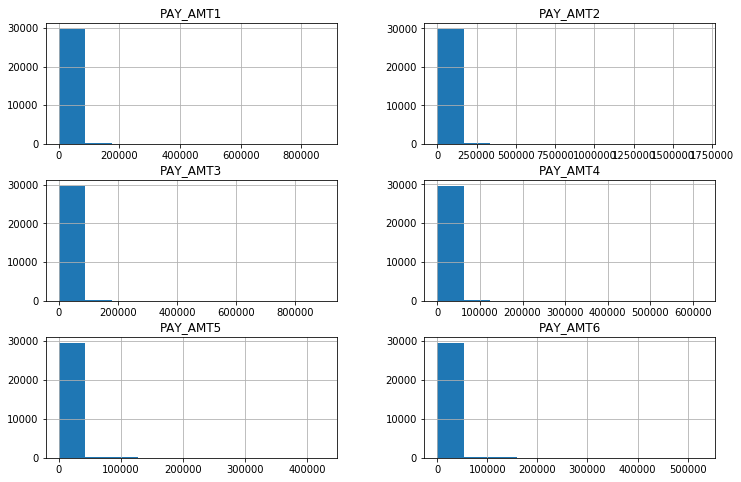

In [31]:
# histogram for preious payments
data.hist(column= payments, figsize=(12, 8))

<b>Conclusion: We will apply normalization in certain models.</b>

### 2. Categorial features

In [32]:
# (old version)
# age_bins = pd.cut(data['AGE'], 10, retbins=True)
# age_bins = np.floor(age_bins).astype(int)
# df_male = data[data['SEX'] == 1]
# df_female = data[data['SEX'] == 2]

# prob_male = df_male.groupby(pd.cut(df_male['AGE'], bins=age_bins))['def_pay'].mean()
# prob_female = df_female.groupby(pd.cut(df_female['AGE'], bins=age_bins))['def_pay'].mean()

# plt.figure(figsize=(18, 6))
# plt.title('Default rate for different age groups')
# plt.bar(range(0, 30, 3), prob_male, width=1, label='Male')
# plt.bar(range(1, 31, 3), prob_female, width=1, label='Female')
# plt.xticks(range(0, 30, 3), prob_male.index)
# plt.legend(loc='upper left')
# plt.show()

#### (1) Sex

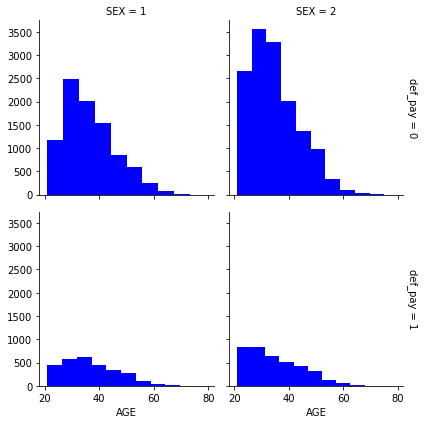

In [33]:
# Sex
# histogram for sex
g1 = sns.FacetGrid(data, col='SEX', row='def_pay', margin_titles=True)
g1.map(plt.hist,'AGE',color='blue')

<b>Conclusion: Sex is a significant feature, and we can infer that male are more likely to default than female.</b>

#### (2) Education

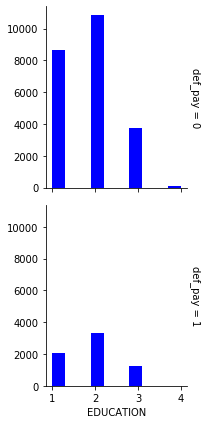

In [34]:
# Education
# histogram for education
g2 = sns.FacetGrid(data,row='def_pay', margin_titles=True)
g2.map(plt.hist,'EDUCATION',color='blue')

<b>Conclusion: Education is a significant feature, and we can infer that people with higher education level are less likely to default.</b>

#### (3) Marriage

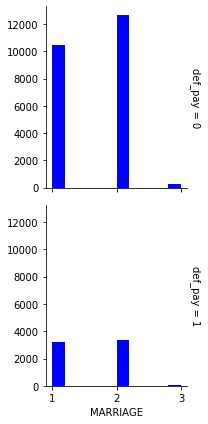

In [35]:
# MARRIAGE
# histogram for marriage
g3 = sns.FacetGrid(data,row='def_pay', margin_titles=True)
g3.map(plt.hist,'MARRIAGE',color='blue')

<b>Conclusion: Marriage is a significant feature, and we can infer that married people are more likely to default than single people.</b>

## Model Building And Evaluation

## Model 1 : Decision Tree

In [36]:
# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

### 1. With feature engineering

In [37]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

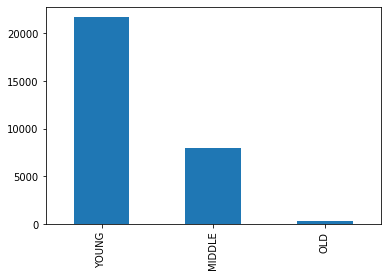

In [38]:
# binning of age
group_age=['YOUNG','MIDDLE','OLD']
data['AGE-BINNED']=pd.cut(data['AGE'],3,labels=group_age)
data['AGE-BINNED'].value_counts().plot(kind='bar')

In [39]:
# label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['AGE-BINNED'] = le.fit_transform(data['AGE-BINNED'])

<b>We will use min-max scaling for numerical features. As there are meaningful negative values, log scaling should not be used. The distribution is not normal, so z-score should not be used. Feature clipping will clip a few values which we believe are in fact normal points. Thus, we choose min-max scaling.</b>

In [40]:
# normalization of certain numerical features
numerical_features_featureengineering = ['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                                         'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data[numerical_features_featureengineering])
data[numerical_features_featureengineering] = scaler.transform(data[numerical_features_featureengineering])

In [41]:
# (log scaling)

# numerical_features_featureengineering = ['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
#                                          'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
# data[numerical_features_featureengineering]=data[numerical_features_featureengineering].transform(lambda x:np.log(x+1))

# from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p, validate=True)
# data[numerical_features_featureengineering]=transformer.transform(data[numerical_features_featureengineering])

In [42]:
# data.isnull().any()

In [43]:
data.to_csv('data/data_decisiontree.csv')

In [44]:
data = pd.read_csv('data/data_decisiontree.csv',index_col = 'ID')

In [45]:
features=['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE-BINNED'] + repayments + bill_amounts + payments
target=['def_pay']

In [46]:
X1=data[features]
y1=data[target]

In [47]:
DTM1_0 = DecisionTreeClassifier()
DTM1_0.fit(X1,y1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [48]:
DTM1_0.get_depth()

43

In [49]:
DTM1_0.get_n_leaves()

4859

In [50]:
# import cross validation
from sklearn.model_selection import cross_val_score, GridSearchCV

In [51]:
score_cv_dt = cross_val_score(DTM1_0, X1, y1, cv=10)

In [52]:
score_cv_dt.mean()

0.7286333333333334

In [53]:
# define the numbers to try out for depth and max number of leaf nodes 
depths = list(range(5, 45, 5))
num_leafs = list(range(500, 5000, 500))

In [54]:
param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

In [55]:
# define the model using GridSearchCV
DTM1 = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)

In [56]:
DTM1.fit(X1,y1)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
     

In [57]:
# find the best parameters
DTM1.best_params_

{'max_depth': 5, 'max_leaf_nodes': 500}

In [58]:
DTM1.best_score_

0.8196333333333335

In [59]:
DTM1_best = DTM1.best_estimator_

In [60]:
joblib.dump(DTM1_best, 'models/DTM1_best.joblib')

['models/DTM1_best.joblib']

In [61]:
DTM1_best = joblib.load('models/DTM1_best.joblib')

#### Model Evaluation

In [62]:
# import evaluation tools
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt

In [63]:
DTM1_pred = DTM1_best.predict(X1)

In [64]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y1, DTM1_pred))
print("Accuracy:",accuracy_score(y1, DTM1_pred, normalize=True, sample_weight=None))

Confusion Matrix: 
 [[22296  1068]
 [ 4211  2425]]
Accuracy: 0.8240333333333333


In [65]:
print(classification_report(y1, DTM1_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.69      0.37      0.48      6636

    accuracy                           0.82     30000
   macro avg       0.77      0.66      0.69     30000
weighted avg       0.81      0.82      0.80     30000



In [66]:
DTM1_proba = DTM1_best.predict_proba(X1)
DTM1_proba = DTM1_proba[:,0]
DTM1_proba

array([0.51351351, 0.56028369, 0.90893551, ..., 0.34108527, 0.90893551,
       0.84174528])

In [67]:
fpr, tpr, thresholds = roc_curve(y1,DTM1_proba,pos_label=0)

In [68]:
auc(fpr, tpr)

0.7633291008438509

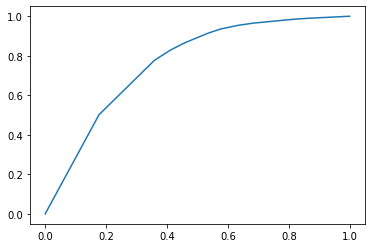

In [69]:
plt.plot(fpr,tpr)

### 2. Without feature engineering

In [70]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [71]:
# define independent variables / attirbutes / features
features = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE'] + repayments + bill_amounts + payments
# define one single target variable / label
target = ['def_pay']

In [72]:
# get defined training dataset
X2 = data[features]
y2 = data[target]

In [73]:
# build a decision tree model with the defalut hyperparameter settings
DTM2_0 = DecisionTreeClassifier()
DTM2_0.fit(X2,y2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [74]:
DTM2_0.get_depth()

43

In [75]:
DTM2_0.get_n_leaves()

4745

In [76]:
# import cross validation
from sklearn.model_selection import cross_val_score, GridSearchCV

In [77]:
# CV
score_cv_dt = cross_val_score(DTM2_0, X2, y2, cv=10)

In [78]:
score_cv_dt.mean()

0.7270666666666666

In [79]:
# define the numbers to try out for depth and max number of leaf nodes 
depths = list(range(5, 45, 5))
num_leafs = list(range(500, 5000, 500))

In [80]:
param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

In [81]:
# define the model using GridSearchCV
DTM2 = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)

In [82]:
DTM2.fit(X2,y2)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
     

In [83]:
# find the best parameters
DTM2.best_params_

{'max_depth': 5, 'max_leaf_nodes': 500}

In [84]:
DTM2.best_score_

0.8196333333333333

In [85]:
DTM2_best = DTM2.best_estimator_

In [86]:
joblib.dump(DTM2_best, 'models/DTM2_best.joblib')

['models/DTM2_best.joblib']

In [87]:
DTM2_best = joblib.load('models/DTM2_best.joblib')

#### Model Evaluation

In [88]:
DTM2_pred = DTM2_best.predict(X2)

In [89]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y2, DTM2_pred))
print("Accuracy:",accuracy_score(y2, DTM2_pred, normalize=True, sample_weight=None))

Confusion Matrix: 
 [[22345  1019]
 [ 4258  2378]]
Accuracy: 0.8241


In [90]:
print(classification_report(y2,DTM2_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89     23364
           1       0.70      0.36      0.47      6636

    accuracy                           0.82     30000
   macro avg       0.77      0.66      0.68     30000
weighted avg       0.81      0.82      0.80     30000



In [91]:
DTM2_proba = DTM2_best.predict_proba(X2)
DTM2_proba = DTM2_proba[:,0]
DTM2_proba

array([0.51351351, 0.56028369, 0.90893551, ..., 0.31451613, 0.90893551,
       0.84174528])

In [92]:
fpr, tpr, thresholds = roc_curve(y2,DTM2_proba,pos_label=0)

In [93]:
auc(fpr, tpr)

0.7631341329850233

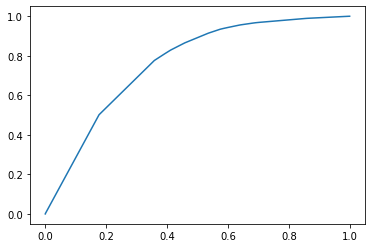

In [94]:
plt.plot(fpr,tpr)

## Model 2 : Logistic regression

### Feature engineering method 1

If we do not conduct scaling on numerical features, logistic regression will give a convergence warning. So we choose to do mix-max scaling for numerical features and need to do one-hot encoding for categorical features. Also, we apply binning for the feature age.

In [95]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [96]:
# binning of age
group_age=['YOUNG','MIDDLE','OLD']
data['AGE-BINNED']=pd.cut(data['AGE'],3,labels=group_age)
data=data.drop(columns='AGE')

In [97]:
# the categorical features to carry out feature engineering
categorical_features = ['AGE-BINNED','SEX', 'EDUCATION', 'MARRIAGE']
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [98]:
# the numerical features to carry out feature engineering
numerical_features_featureengineering = ['LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                                         'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                                         'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data[numerical_features_featureengineering])
data[numerical_features_featureengineering] = scaler.transform(data[numerical_features_featureengineering])

In [99]:
# Export preprocessed data
data.to_csv('data/data_logistic1.csv')

In [100]:
# Read preprocessed data from local drive
data = pd.read_csv('data/data_logistic1.csv',index_col = 'ID')

In [101]:
X3 = data.drop(columns='def_pay')
y3=data['def_pay']

In [102]:
# import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

In [103]:
lr1 = LogisticRegression(penalty='l1', solver='saga',max_iter=1000)

In [104]:
lr1

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
# change target column to array
y3_act = y3.values.ravel()

In [106]:
score_cv_lr = cross_val_score(lr1, X3, y3_act, cv=10)

In [107]:
score_cv_lr.mean()

0.8095333333333332

In [108]:
joblib.dump(lr1, 'models/Logistic1.joblib')

['models/Logistic1.joblib']

In [109]:
lr1 = joblib.load('models/Logistic1.joblib')

#### Model Evaluation

In [110]:
from sklearn.model_selection import cross_val_predict

In [111]:
# predict value of target based on cross validation
lr1_pred = cross_val_predict(lr1, X3, y3_act, cv=10)

In [112]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y3_act, lr1_pred))
print("Accuracy:",accuracy_score(y3_act, lr1_pred, normalize=True, sample_weight=None))

Confusion Matrix: 
 [[22731   633]
 [ 5081  1555]]
Accuracy: 0.8095333333333333


In [113]:
print(classification_report(y3_act, lr1_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     23364
           1       0.71      0.23      0.35      6636

    accuracy                           0.81     30000
   macro avg       0.76      0.60      0.62     30000
weighted avg       0.79      0.81      0.77     30000



In [114]:
lr1_proba = cross_val_predict(lr1, X3, y3_act, cv=10, method='predict_proba')
lr1_proba = lr1_proba[:,0]
lr1_proba

array([0.4706509 , 0.84470115, 0.80299283, ..., 0.18265808, 0.79534432,
       0.73232564])

In [115]:
fpr, tpr, thresholds = roc_curve(y3_act,lr1_proba,pos_label=0)

In [116]:
auc(fpr, tpr)

0.720131605771758

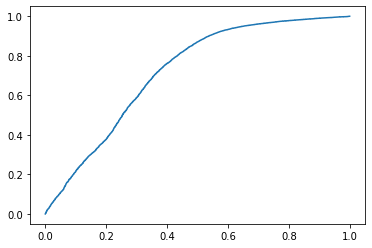

In [117]:
plt.plot(fpr,tpr)

### Feature engineering method 2

If we do not conduct scaling on numerical features, logistic regression will give a convergence warning. So we choose to do mix-max scaling for numerical features and need to do one-hot encoding for categorical features.

In [118]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [119]:
# the categorical features to carry out feature engineering
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [120]:
# the numerical features to carry out feature engineering
numerical_features_featureengineering = ['AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                                         'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                                         'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data[numerical_features_featureengineering])
data[numerical_features_featureengineering] = scaler.transform(data[numerical_features_featureengineering])

In [121]:
# Export preprocessed data
data.to_csv('data/data_logistic2.csv')

In [122]:
# Read preprocessed data from local drive
data = pd.read_csv('data/data_logistic2.csv',index_col = 'ID')

In [123]:
X4= data.drop(columns='def_pay')
y4=data['def_pay']

In [124]:
# import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

In [125]:
lr2 = LogisticRegression(penalty='l1', solver='saga',max_iter=1000)

In [126]:
lr2

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [127]:
# change target column to array
y4_act = y4.values.ravel()

In [128]:
score_cv_lr = cross_val_score(lr2, X4, y4_act, cv=10)

In [129]:
score_cv_lr.mean()

0.8097333333333333

In [130]:
joblib.dump(lr2, 'models/Logistic2.joblib')

['models/Logistic2.joblib']

In [131]:
lr2 = joblib.load('models/Logistic2.joblib')

#### Model Evaluation

In [132]:
# predict value of target based on cross validation
lr2_pred = cross_val_predict(lr2, X4, y4_act, cv=10)

In [133]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y4_act, lr2_pred))
print("Accuracy:",accuracy_score(y4_act, lr2_pred, normalize=True, sample_weight=None))

Confusion Matrix: 
 [[22737   627]
 [ 5081  1555]]
Accuracy: 0.8097333333333333


In [134]:
print(classification_report(y4_act, lr2_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     23364
           1       0.71      0.23      0.35      6636

    accuracy                           0.81     30000
   macro avg       0.76      0.60      0.62     30000
weighted avg       0.79      0.81      0.77     30000



In [135]:
lr2_proba = cross_val_predict(lr2, X4, y4_act, cv=10, method='predict_proba')
lr2_proba = lr2_proba[:,0]
lr2_proba

array([0.47894234, 0.84629284, 0.79781481, ..., 0.17639517, 0.80254868,
       0.73687344])

In [136]:
fpr, tpr, thresholds = roc_curve(y4_act,lr2_proba,pos_label=0)

In [137]:
auc(fpr, tpr)

0.7200668271790347

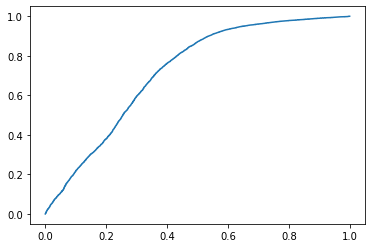

In [138]:
plt.plot(fpr,tpr)

## Model 3 : K-means clustering

In [139]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [140]:
# the categorical features to carry out feature engineering
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

# the numerical features to carry out feature engineering
numerical_features_featureengineering = ['AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

In [141]:
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [142]:
# Normalize attributes
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(data[numerical_features_featureengineering])
data[numerical_features_featureengineering] = scaler.transform(data[numerical_features_featureengineering])

In [143]:
# Export preprocessed data
data.to_csv('data/data_kmeans.csv')

In [144]:
# Read preprocessed data from local drive
data = pd.read_csv('data/data_kmeans.csv',index_col = 'ID')

In [145]:
X = data.drop(columns='def_pay')
y = data['def_pay']

In [146]:
# import KMeans from sklearn
from sklearn.cluster import KMeans

In [147]:
# set number of clusters
kmeansmodel = KMeans(n_clusters=2)

In [148]:
# fit data
kmeansmodel.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [149]:
# centroids
centroids = kmeansmodel.cluster_centers_
centroids

array([[ 1.77453692e-01,  2.61131125e-01,  1.87938999e-01,
         1.72986142e-01,  1.70524584e-01,  1.65892552e-01,
         1.62526103e-01,  1.60494843e-01,  1.89733502e-01,
         1.10834692e-01,  1.11241894e-01,  1.99514355e-01,
         1.19436315e-01,  2.89816477e-01,  7.04835340e-03,
         3.92986284e-03,  6.48740401e-03,  8.41937521e-03,
         1.20046241e-02,  1.05731162e-02,  5.91976207e-01,
         1.19459997e-13,  3.14560526e-01,  7.90989053e-03,
         5.62931089e-01,  9.93482250e-03],
       [ 1.38617420e-01,  2.37081414e-01,  2.09896457e-01,
         2.01803198e-01,  1.97689653e-01,  1.91336198e-01,
         1.85461717e-01,  1.82461083e-01,  1.94197269e-01,
         1.15183784e-01,  1.13175238e-01,  2.02423127e-01,
         1.21936597e-01,  2.92002473e-01,  5.85452185e-03,
         3.05445284e-03,  5.10239898e-03,  7.05025171e-03,
         1.04146500e-02,  9.07762926e-03,  6.16820455e-01,
         1.00000000e+00, -1.29618538e-14, -1.41640172e-15,
         5.00

In [150]:
# centroids
iteration = kmeansmodel.n_iter_
iteration

2

In [151]:
# SSD
SSD = kmeansmodel.inertia_
SSD

22829.750196235036

In [152]:
# centroids
distance = kmeansmodel.transform(X)
distance

array([[1.34928576, 0.78638601],
       [1.27253326, 0.72688603],
       [1.21512345, 0.63662053],
       ...,
       [1.41685458, 0.97127769],
       [1.09809229, 1.64263493],
       [1.34929523, 0.82421415]])

In [153]:
# Get Labels of each point 
data_label = kmeansmodel.labels_

In [154]:
# Create comparison table between actual def_pay and predict cluster
data_comparison=pd.DataFrame(data_label,y,columns=['cluster'])
data_comparison

,cluster
def_pay,
1,1
1,1
0,1
0,1
0,1
...,...
0,0
0,0
1,1


In [155]:
# Find corresponding instances that belong to each def_pay type
data_nondefault = data_comparison.loc[0]
data_default = data_comparison.loc[1]

In [156]:
# Count value for different cluster regarding one type of def_pay
data_nondefault[data_nondefault.columns[0]].value_counts()

0    12508
1    10856
Name: cluster, dtype: int64

In [157]:
data_default[data_default.columns[0]].value_counts()

1    3341
0    3295
Name: cluster, dtype: int64

<b>Based on majority rule, cluster 0 is default, cluster 1 is nondefault.</b>

In [158]:
# the results above can be regarded as a "confusion matrix"
kmeans_TN=data_nondefault.loc[data_nondefault.cluster == 1, 'cluster'].count()
kmeans_TP=data_default.loc[data_default.cluster == 0, 'cluster'].count()
kmeans_FN=data_default.loc[data_default.cluster == 1, 'cluster'].count()
kmeans_FP=data_nondefault.loc[data_nondefault.cluster == 0, 'cluster'].count()

In [159]:
kmeans_accuracy=(kmeans_TN+kmeans_TP)/(kmeans_TN+kmeans_TP+kmeans_FN+kmeans_FP)
kmeans_accuracy

0.4717

### Model Evaluation

In this case, the cardinality is fixed due to that the number of clusters is fixed, so the way of checking if cardinality correlates with magnitude cannot be used. Thus, the only way is to interpret the above results, which kind of serve as a "confusion matrix". As shown in the model building part, the accuracy is around 0.5, which is similar to random guess.

## Model 4 : Naive Bayes

### 1. Method 1: Discretizing Continuous Feature for Naive Bayes

#### (1) With data normalization and equal interval bins

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

##### i. Age

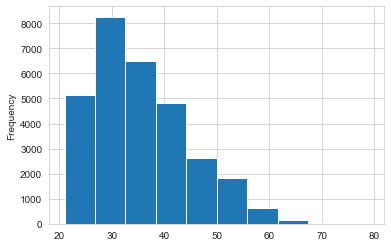

In [164]:
data['AGE'].plot(kind='hist')

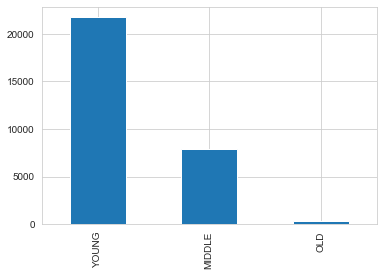

In [165]:
# binning of age
group_age=['YOUNG','MIDDLE','OLD']
data['AGE_BINNED']=pd.cut(data['AGE'],3,labels=group_age)
data['AGE_BINNED'].value_counts().plot(kind='bar')

In [166]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()

In [167]:
data['AGE_encoded'] = le.fit_transform(data['AGE_BINNED'])

##### ii. Limit Balance

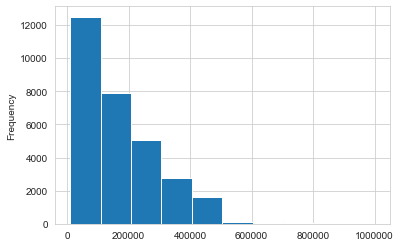

In [168]:
data['LIMIT_BAL'].plot(kind='hist')

In [169]:
# Normalize limit balance data
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
log.fit(data[['LIMIT_BAL']])
data['LIMIT_BAL_log'] =log.transform(data[['LIMIT_BAL']])

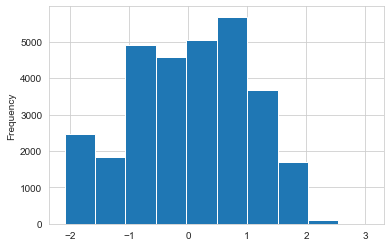

In [170]:
data['LIMIT_BAL_log'].plot(kind='hist')

In [171]:
pd.cut(data['LIMIT_BAL_log'], bins=5).value_counts()

(-0.033, 1.0]       10723
(-1.066, -0.033]     9501
(1.0, 2.033]         5345
(-2.104, -1.066]     4311
(2.033, 3.066]        120
Name: LIMIT_BAL_log, dtype: int64

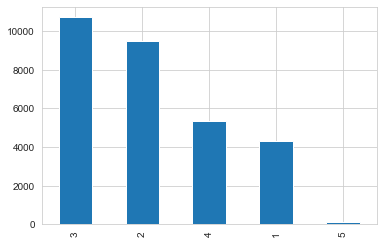

In [172]:
# binning of limit balance
data['LIMIT_BAL_BINNED']=pd.cut(data['LIMIT_BAL_log'],5,labels=range(1,6))
data['LIMIT_BAL_BINNED'].value_counts().plot(kind='bar')

##### iii. Previous Panyments

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e9bad50>,
      dtype=object)

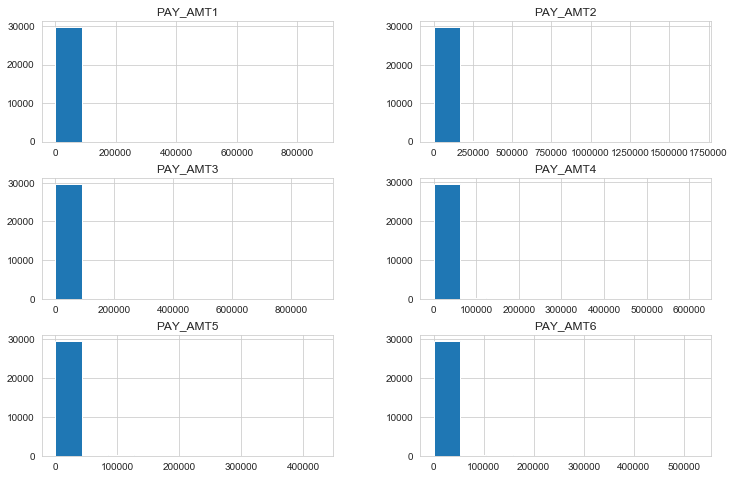

In [173]:
# histogram for preious payments
data.hist(column= payments, figsize=(12, 8))

In [174]:
# Normalize previous payments data
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
for x in payments:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21d32690>,
      dtype=object)

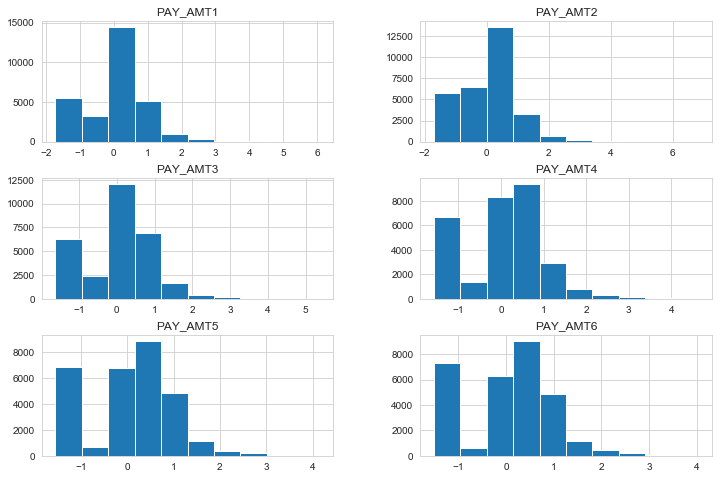

In [175]:
data.hist(column= payments, figsize=(12, 8))

In [176]:
pd.cut(data['PAY_AMT1'], bins=5).value_counts()

(-0.164, 1.396]     19686
(-1.732, -0.164]     8747
(1.396, 2.957]       1394
(2.957, 4.517]        167
(4.517, 6.077]          6
Name: PAY_AMT1, dtype: int64

In [177]:
# binning of previous payments
for x in payments:
    data[x+'_BINNED']=pd.cut(data[x],5,labels=range(1,6))

##### iv. Bill Statements

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21194790>,
      dtype=object)

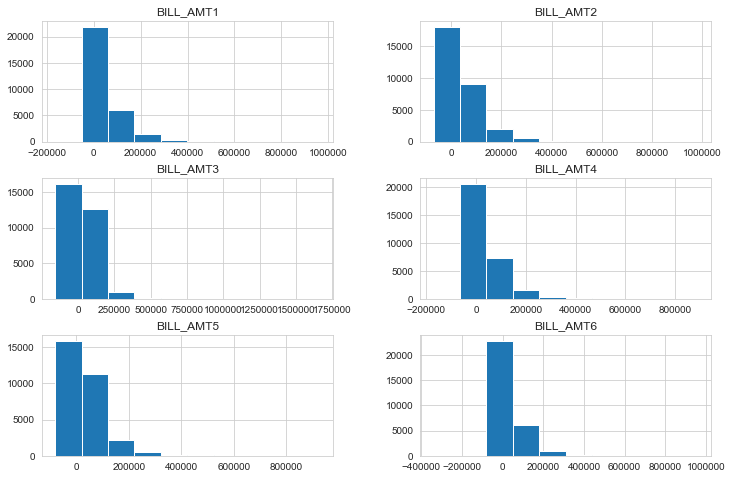

In [178]:
# histogram for bill statements
data.hist(column= bill_amounts, figsize=(12, 8))

In [179]:
pd.cut(data['BILL_AMT1'], bins=3).value_counts()

(-166710.091, 211117.0]    28671
(211117.0, 587814.0]        1317
(587814.0, 964511.0]          12
Name: BILL_AMT1, dtype: int64

In [180]:
# binning of bill statements
for x in bill_amounts:
    data[x+'_BINNED']=pd.cut(data[x],3,labels=range(1,4))

##### v. Repayments

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a212e7bd0>,
      dtype=object)

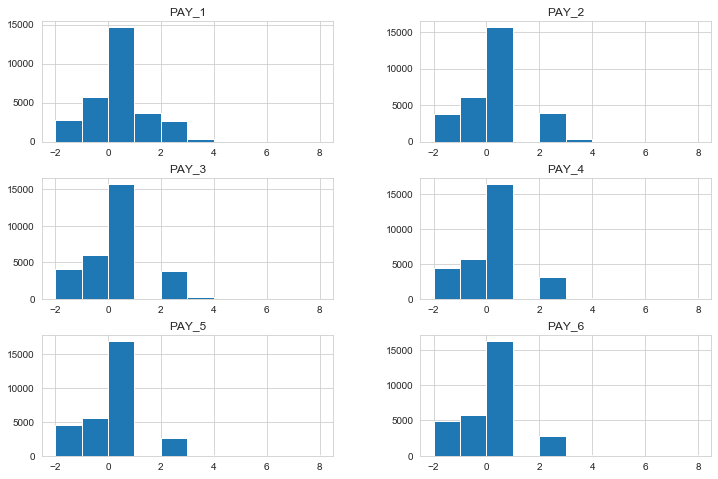

In [181]:
data.hist(column= repayments, figsize=(12, 8))

In [182]:
# MutilinomialNB disallow negative input, add a constant to all repayments status value
data[repayments]=data[repayments]+9

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23565450>,
      dtype=object)

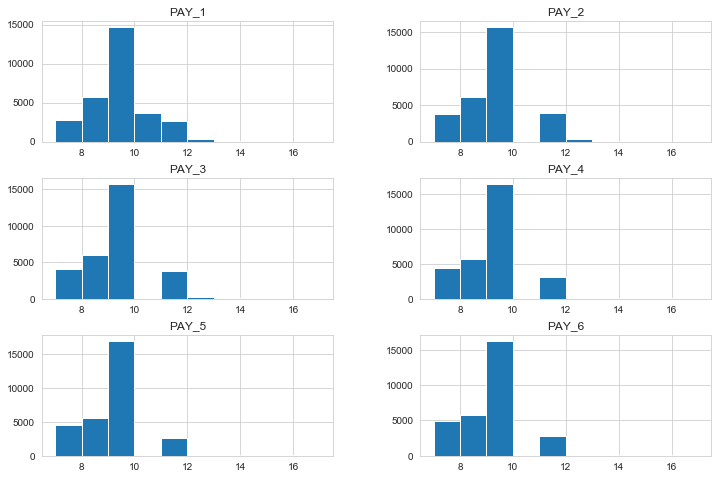

In [183]:
data.hist(column= repayments, figsize=(12, 8))

#### Model Building

In [184]:
bill_amounts_binned = ['BILL_AMT1_BINNED', 'BILL_AMT2_BINNED', 'BILL_AMT3_BINNED', 'BILL_AMT4_BINNED', 'BILL_AMT5_BINNED', 'BILL_AMT6_BINNED']
payments_binned = ['PAY_AMT1_BINNED', 'PAY_AMT2_BINNED', 'PAY_AMT3_BINNED', 'PAY_AMT4_BINNED', 'PAY_AMT5_BINNED', 'PAY_AMT6_BINNED']          
features=['LIMIT_BAL_BINNED','SEX','EDUCATION','MARRIAGE','AGE_encoded'] + repayments + bill_amounts_binned + payments_binned
X=data[features]
y=data['def_pay']

In [185]:
#Import Multinomial Naive Bayes model from sklearn
from sklearn.naive_bayes import MultinomialNB
#Create a Multinomial Bayes Classifier
mnb = MultinomialNB()

#### Model Evaluation

In [186]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt

In [187]:
# Accuracy from cross validation 
# import cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict
score = cross_val_score(mnb,X,y,cv=10)
score.mean()

0.7825666666666666

In [188]:
# get predicted class for y
y_pred_class = cross_val_predict(mnb,X,y,cv=10)

In [189]:
pred_proba = cross_val_predict(mnb, X,y,cv=10, method = 'predict_proba')
pred_proba

array([[0.57882863, 0.42117137],
       [0.71128347, 0.28871653],
       [0.80552591, 0.19447409],
       ...,
       [0.63544209, 0.36455791],
       [0.83015017, 0.16984983],
       [0.76591522, 0.23408478]])

In [190]:
print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred_class))
print("Classification Report:","\n", classification_report(y, y_pred_class))

Confusion Matrix: 
 [[23287    77]
 [ 6446   190]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       0.71      0.03      0.06      6636

    accuracy                           0.78     30000
   macro avg       0.75      0.51      0.47     30000
weighted avg       0.77      0.78      0.70     30000



In [191]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y, pred_proba[:,1], pos_label=1)

In [192]:
# Area under ROC curve
roc_auc=auc(fpr,tpr)
roc_auc

0.7167614162022551

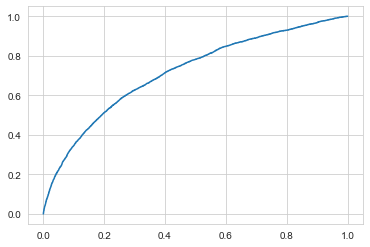

In [193]:
plt.plot(fpr,tpr)

#### (2)  With equal quantity bins

##### i. Age

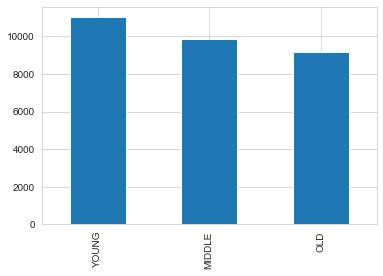

In [194]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')
# binning of age
group_age=['YOUNG','MIDDLE','OLD']
data['AGE_BINNED']=pd.qcut(data['AGE'],3,labels=group_age)
data['AGE_BINNED'].value_counts().plot(kind='bar')

In [195]:
data['AGE_BINNED'].value_counts()

YOUNG     11013
MIDDLE     9843
OLD        9144
Name: AGE_BINNED, dtype: int64

In [196]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()

In [197]:
data['AGE_encoded'] = le.fit_transform(data['AGE_BINNED'])

In [198]:
data['AGE_BINNED']

ID
1         YOUNG
2         YOUNG
3        MIDDLE
4        MIDDLE
5           OLD
          ...  
29996    MIDDLE
29997       OLD
29998    MIDDLE
29999       OLD
30000       OLD
Name: AGE_BINNED, Length: 30000, dtype: category
Categories (3, object): [YOUNG < MIDDLE < OLD]

##### ii. Limit Balance

In [199]:
pd.qcut(data['LIMIT_BAL'],5).value_counts()

(9999.999, 50000.0]      7676
(100000.0, 180000.0]     6123
(270000.0, 1000000.0]    5958
(180000.0, 270000.0]     5421
(50000.0, 100000.0]      4822
Name: LIMIT_BAL, dtype: int64

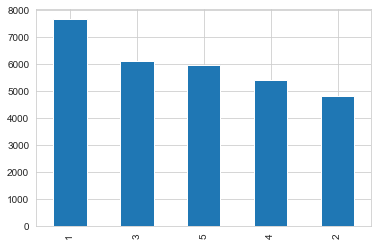

In [200]:
# binning of limit balance
data['LIMIT_BAL_BINNED']=pd.qcut(data['LIMIT_BAL'],5,labels=range(1,6))
data['LIMIT_BAL_BINNED'].value_counts().plot(kind='bar')

##### iii. Previous Payments

In [201]:
# binning of previous payments
for x in payments:
    data[x+'_BINNED']=pd.qcut(data[x],4,labels=range(1,5))

##### iv. Bill Statement

In [202]:
# binning of bill statements
for x in bill_amounts:
    data[x+'_BINNED']=pd.qcut(data[x],3,labels=range(1,4))

##### v. Repayments

In [203]:
data[repayments]=data[repayments]+9

#### Model Building

In [204]:
bill_amounts_binned = ['BILL_AMT1_BINNED', 'BILL_AMT2_BINNED', 'BILL_AMT3_BINNED', 'BILL_AMT4_BINNED', 'BILL_AMT5_BINNED', 'BILL_AMT6_BINNED']
payments_binned = ['PAY_AMT1_BINNED', 'PAY_AMT2_BINNED', 'PAY_AMT3_BINNED', 'PAY_AMT4_BINNED', 'PAY_AMT5_BINNED', 'PAY_AMT6_BINNED']          
features=['LIMIT_BAL_BINNED','SEX','EDUCATION','MARRIAGE','AGE_encoded'] + repayments + bill_amounts_binned + payments_binned
X=data[features]
y=data['def_pay']

In [205]:
#Import Multinomial Naive Bayes model from sklearn
from sklearn.naive_bayes import MultinomialNB
#Create a Multinomial Bayes Classifier
mnb = MultinomialNB()

#### Model Evaluation

In [206]:
# Accuracy from cross validation 
# import cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict
score = cross_val_score(mnb,X,y,cv=10)
score.mean()

0.7847666666666666

In [207]:
# get predicted class for y
y_pred_class = cross_val_predict(mnb,X,y,cv=10)

In [208]:
pred_proba = cross_val_predict(mnb, X,y,cv=10, method = 'predict_proba')
pred_proba

array([[0.33722448, 0.66277552],
       [0.61905639, 0.38094361],
       [0.74509993, 0.25490007],
       ...,
       [0.60068163, 0.39931837],
       [0.8651345 , 0.1348655 ],
       [0.62518655, 0.37481345]])

In [209]:
print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred_class))
print("Classification Report:","\n", classification_report(y, y_pred_class))

Confusion Matrix: 
 [[22350  1014]
 [ 5443  1193]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     23364
           1       0.54      0.18      0.27      6636

    accuracy                           0.78     30000
   macro avg       0.67      0.57      0.57     30000
weighted avg       0.75      0.78      0.74     30000



In [210]:
fpr, tpr, thresholds = roc_curve(y, pred_proba[:,1], pos_label=1)

In [211]:
# Area under ROC curve
roc_auc=auc(fpr,tpr)
roc_auc

0.6880550764642162

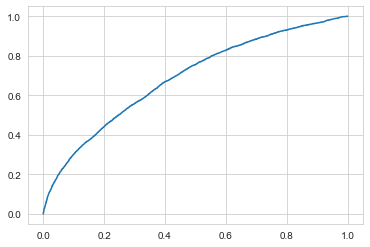

In [212]:
plt.plot(fpr,tpr)

### 2. Method 2: Use GaussianNB for Continuous Features and MultinomialNB for Categorical Features respectively

In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

#### Normalize skewed features

##### i. Limit Balance

In [214]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
log.fit(data[['LIMIT_BAL']])
data['LIMIT_BAL_log'] =log.transform(data[['LIMIT_BAL']])

##### ii. Previous Payments

In [215]:
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
for x in payments:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

##### iii. Repayments

In [216]:
data[repayments]=data[repayments]+9

#### Model Building

In [217]:
# define independent attributes 
features1=['LIMIT_BAL','AGE'] + bill_amounts + payments

# assign values for independent variables and target variable ('Personal Loan')
X1 = data [features1]
y = data ['def_pay']

In [218]:
#Import Gaussian Naive Bayes model from sklearn
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Naive Bayes Classifier
gnb = GaussianNB() 

In [219]:
# import cross validation
from sklearn.model_selection import cross_val_score,cross_val_predict
pred_proba = cross_val_predict(gnb, X1,y,cv=10, method = 'predict_proba')
pred_proba

array([[0.63830326, 0.36169674],
       [0.70282364, 0.29717636],
       [0.71676872, 0.28323128],
       ...,
       [0.67900981, 0.32099019],
       [0.73704957, 0.26295043],
       [0.6902985 , 0.3097015 ]])

In [220]:
# define independent attributes 
features2=['SEX','EDUCATION','MARRIAGE'] + repayments

# assign values for independent variables and target variable ('Personal Loan')
X2 = data [features2]
y = data ['def_pay']

In [221]:
#Import Multinomial Naive Bayes model from sklearn
from sklearn.naive_bayes import MultinomialNB
#Create a Multinomial Bayes Classifier
mnb = MultinomialNB()

In [222]:
score = cross_val_score(mnb,X2,y,cv=10)
score.mean()

0.7787999999999999

In [223]:
pred_proba2 = cross_val_predict(mnb, X2,y,cv=10, method = 'predict_proba')
pred_proba2

array([[0.76032481, 0.23967519],
       [0.79680859, 0.20319141],
       [0.79474403, 0.20525597],
       ...,
       [0.74670541, 0.25329459],
       [0.76307536, 0.23692464],
       [0.7626766 , 0.2373234 ]])

In [224]:
predictions=[]
for x in range(0,30000):
    if pred_proba2[x][0]*pred_proba[x][0] > pred_proba2[x][1]*pred_proba[x][1]:
        predictions.append(0)
    else:
        predictions.append(1)

#### Model Evaluation

In [225]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
accuracy_score(y, predictions, normalize=True, sample_weight=None)

0.7787666666666667

In [226]:
# Do majority-class prediction (not accept: 0) -> Benchmark model
pred_val_maj = np.zeros((30000,),dtype=int)

In [227]:
# print the accurary rate
print("Accuracy of Benchmark Model:","\n", accuracy_score(y, pred_val_maj, normalize=True, sample_weight=None))
print("Accuracy of Naive Bayes Model:","\n", accuracy_score(y, predictions, normalize=True, sample_weight=None))

Accuracy of Benchmark Model: 
 0.7788
Accuracy of Naive Bayes Model: 
 0.7787666666666667


In [228]:
# print the confusion matrix
print("Confusion Matrix of Benchmark Model:", "\n", confusion_matrix(y, pred_val_maj))
print("Confusion Matrix of Naive Bayes Model:", "\n", confusion_matrix(y, predictions))

Confusion Matrix of Benchmark Model: 
 [[23364     0]
 [ 6636     0]]
Confusion Matrix of Naive Bayes Model: 
 [[23363     1]
 [ 6636     0]]


In [229]:
# print the classification report with precision, recall
print("Classification Report of Benchmark Model:", "\n", classification_report(y, pred_val_maj,zero_division=True))
print("Classification Report of Naive Bayes Model:","\n",classification_report(y, predictions,zero_division=True))

Classification Report of Benchmark Model: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       1.00      0.00      0.00      6636

    accuracy                           0.78     30000
   macro avg       0.89      0.50      0.44     30000
weighted avg       0.83      0.78      0.68     30000

Classification Report of Naive Bayes Model: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     23364
           1       0.00      0.00      0.00      6636

    accuracy                           0.78     30000
   macro avg       0.39      0.50      0.44     30000
weighted avg       0.61      0.78      0.68     30000



## Model 5 : K Nearest Neighbor

KNN performs better when all features are numerical and continuous, here, we map all categorical features to a numerical values.

In [230]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [231]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')
# Import module to standardize the scale
from sklearn.preprocessing import StandardScaler
# Create instance of the standard scaler
scaler = StandardScaler()
scaler.fit(data.drop('def_pay', axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [232]:
scaled_features = scaler.transform(data.drop('def_pay',axis=1))
scaled_features

array([[-1.13672015,  0.81016074,  0.25711877, ..., -0.30806256,
        -0.31413612, -0.29338206],
       [-0.3659805 ,  0.81016074,  0.25711877, ..., -0.24422965,
        -0.31413612, -0.18087821],
       [-0.59720239,  0.81016074,  0.25711877, ..., -0.24422965,
        -0.24868274, -0.01212243],
       ...,
       [-1.05964618, -1.23432296,  0.25711877, ..., -0.03996431,
        -0.18322937, -0.11900109],
       [-0.67427636, -1.23432296,  1.66316381, ..., -0.18512036,
         3.15253642, -0.19190359],
       [-0.90549825, -1.23432296,  0.25711877, ..., -0.24422965,
        -0.24868274, -0.23713013]])

In [233]:
# Use the scaled features to creata a data frame
features=pd.DataFrame(scaled_features,columns=data.columns[:-1])

In [234]:
# Import module to split the data
from sklearn.model_selection import train_test_split
X=features
y=data['def_pay']

In [235]:
# Import module for KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [236]:
from sklearn.model_selection import cross_val_score,cross_val_predict
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

In [237]:
scores.mean()

0.7925666666666668

In [238]:
# get predicted class for y
y_pred_class = cross_val_predict(knn,X,y,cv=10)

In [239]:
# Import classification report and confusion matrix to evaluate predictions
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred_class))
print("Classification Report:","\n", classification_report(y, y_pred_class))
cmat = confusion_matrix(y, y_pred_class)
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion Matrix: 
 [[21461  1903]
 [ 4320  2316]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     23364
           1       0.55      0.35      0.43      6636

    accuracy                           0.79     30000
   macro avg       0.69      0.63      0.65     30000
weighted avg       0.77      0.79      0.77     30000

Accuracy Rate: 0.7925666666666666
Misclassification Rate: 0.20743333333333333


### Evaluate alternative K-values for better predictions

In [240]:
error_rate = []
for i in range(1,150):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    y_pred_class = cross_val_predict(knn,X,y,cv=10)
    error_rate.append(np.mean(y_pred_class != y))

Text(0, 0.5, 'Error Rate')

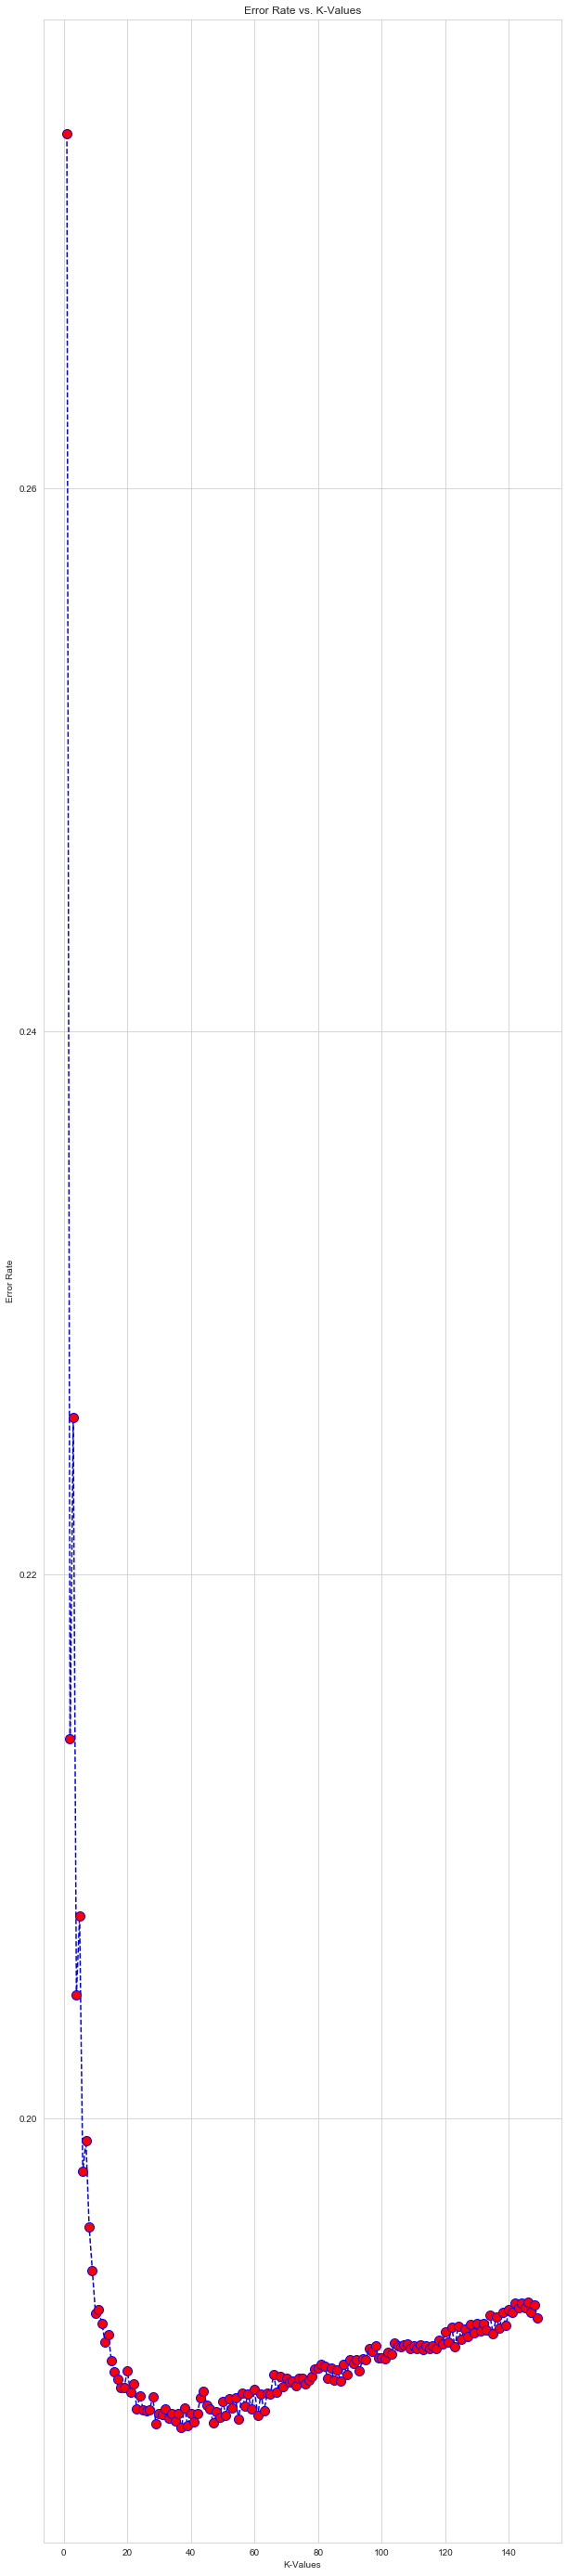

In [241]:
# Configure and plot error rate over k values
plt.figure(figsize=(10,50))
plt.plot(range(1,150), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

The k-value of 23 seems to give a decent error rate without too much noise, as we see with k-values of 28 and larger.

### Fine tune the model

In [242]:
# Retrain model using optimal k-value
knn = KNeighborsClassifier(n_neighbors=23)
y_pred_class = cross_val_predict(knn,X,y,cv=10)

### Model Evaluation

In [243]:
cmat = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:", "\n", confusion_matrix(y, y_pred_class))
print("Classification Report:","\n", classification_report(y, y_pred_class))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion Matrix: 
 [[22191  1173]
 [ 4506  2130]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.95      0.89     23364
           1       0.64      0.32      0.43      6636

    accuracy                           0.81     30000
   macro avg       0.74      0.64      0.66     30000
weighted avg       0.79      0.81      0.79     30000

Accuracy Rate: 0.8107
Misclassification Rate: 0.1893


In [244]:
from sklearn.model_selection import cross_val_score,cross_val_predict
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
scores.mean()

0.8107